In [47]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zf = "/content/cell-images-for-detecting-malaria.zip"
target_dir = "/content/dataset/cell-images-for-detecting-malaria"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [4]:
#importing basic libraries
import numpy as np #for handling arrays
import pandas as pd #for handling data
import matplotlib.pyplot as plt #for visualization
import os, random

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping

import cv2

In [5]:
#define directories
img_dir = "/content/dataset/cell-images-for-detecting-malaria/cell_images/cell_images"
uninfected = "/content/dataset/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected"
parasitized = "/content/dataset/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized"
classes = os.listdir(img_dir)
print(classes)

['Uninfected', 'Parasitized']


In [6]:
# Here we print the number of data in each file that ends with a certain pattern.
print("uninfected count:  ",len(os.listdir(img_dir+"/Uninfected")))
print("Parasitized count:  ",len(os.listdir(img_dir+"/Parasitized")))

uninfected count:   13780
Parasitized count:   13780


**Images of Uninfected**

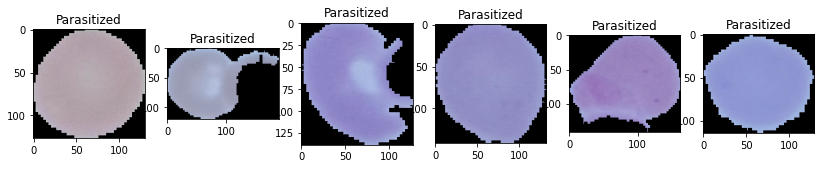

In [7]:
plt.figure(figsize=(14,14))
for i in range(6):
    plt.subplot(2,6,i+1)
    type2="Parasitized"
    imgdir = uninfected
    imgfile = np.random.choice(os.listdir(imgdir))
    img = cv2.imread(imgdir+"/"+imgfile)
    plt.imshow(img)
    plt.title(type2)
plt.show()

**Images of Paratisitized**

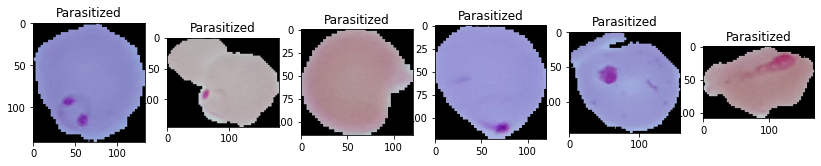

In [8]:
plt.figure(figsize=(14,14))
for i in range(6):
    plt.subplot(2,6,i+1)
    type2="Parasitized"
    imgdir = parasitized
    imgfile = np.random.choice(os.listdir(imgdir))
    img = cv2.imread(imgdir+"/"+imgfile)
    plt.imshow(img)
    plt.title(type2)
plt.show()

# **Data Augmentation**

In [9]:
#Defining image data generator
img_shape = (130, 130, 3)
train_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1./255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest',
                               validation_split=0.2
                               )
test_gen=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [10]:
train = train_gen.flow_from_directory(img_dir,
                                      target_size=img_shape[:2],
                                      color_mode='rgb',
                                      batch_size=32,
                                      class_mode='binary',
                                      subset='training',
                                      shuffle=True)
validation = test_gen.flow_from_directory(img_dir,
                                           target_size=img_shape[:2],
                                           color_mode='rgb',
                                           batch_size=32,
                                           class_mode='binary',
                                           subset='validation',
                                           shuffle=False)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [11]:
train.class_indices

{'Parasitized': 0, 'Uninfected': 1}

**VGG16 MODEL**

In [12]:
head_model = VGG16(input_shape = (130, 130, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [13]:
for layer in head_model.layers:
    layer.trainable = False

In [14]:
#Flatten the output layer to 1 dimension
base_model = head_model.output
base_model = Flatten(name="flatten")(base_model)

# Add a fully connected layer with 512 hidden units and ReLU activation
base_model = Dense(256, activation='relu')(base_model)

# Add a dropout rate of 0.5
base_model = Dropout(0.5)(base_model)

# Add a final sigmoid layer for classification
base_model = Dense(1, activation='sigmoid')(base_model)

model = tf.keras.models.Model(head_model.input, base_model)

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy',metrics = ['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 130, 130, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 130, 130, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 130, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 65, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 65, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 65, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
early = EarlyStopping(monitor="loss", mode="min", patience=3)

In [16]:
vgghist= model.fit(train, validation_data=validation, steps_per_epoch=100, epochs=10,callbacks=early)

Epoch 1/10
100/100 [==============================] - 1174s 12s/step - loss: 0.5804 - acc: 0.7581 - val_loss: 0.3242 - val_acc: 0.8544
Epoch 2/10
100/100 [==============================] - 1133s 11s/step - loss: 0.3223 - acc: 0.8694 - val_loss: 0.2523 - val_acc: 0.8964
Epoch 3/10
100/100 [==============================] - 1120s 11s/step - loss: 0.2983 - acc: 0.8669 - val_loss: 0.2480 - val_acc: 0.9065
Epoch 4/10
100/100 [==============================] - 1115s 11s/step - loss: 0.2750 - acc: 0.8928 - val_loss: 0.2532 - val_acc: 0.8862
Epoch 5/10
100/100 [==============================] - 1119s 11s/step - loss: 0.2744 - acc: 0.8881 - val_loss: 0.2187 - val_acc: 0.9107
Epoch 6/10
100/100 [==============================] - 1118s 11s/step - loss: 0.2790 - acc: 0.8931 - val_loss: 0.3367 - val_acc: 0.8495
Epoch 7/10
100/100 [==============================] - 1107s 11s/step - loss: 0.2748 - acc: 0.8953 - val_loss: 0.3130 - val_acc: 0.8584
Epoch 8/10
100/100 [==============================] - 1

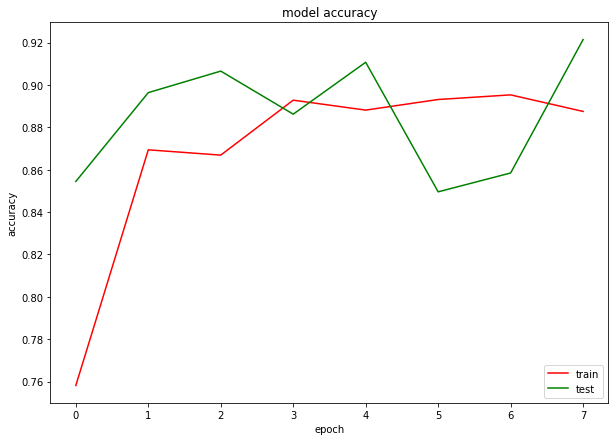

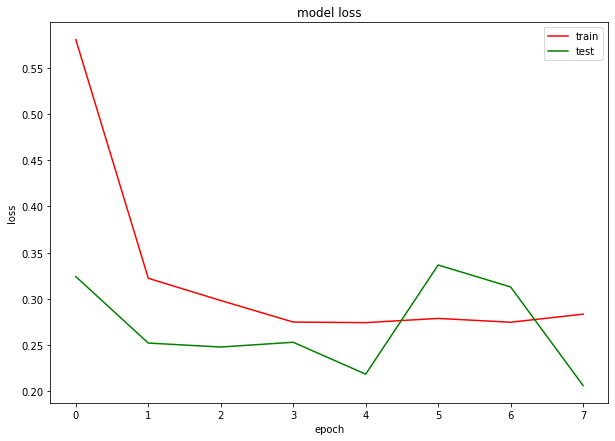

In [17]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(vgghist.history['acc'], color='red')
ax.plot(vgghist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(vgghist.history['loss'], color='red')
ax.plot(vgghist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()